In [1]:
import random
import time

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from typing import List

from src.tensor import Tensor
# from src.tensor.device import Device
from src.nn import Module, Linear, Sequential
from src.nn.optimizer import SGD, Optimizer
from src.nn.loss import MSELoss, BCELoss, CrossEntropyLoss
from src.nn.activation import Tanh


np.random.seed(1337)
random.seed(1337)

(200, 2) (200,)


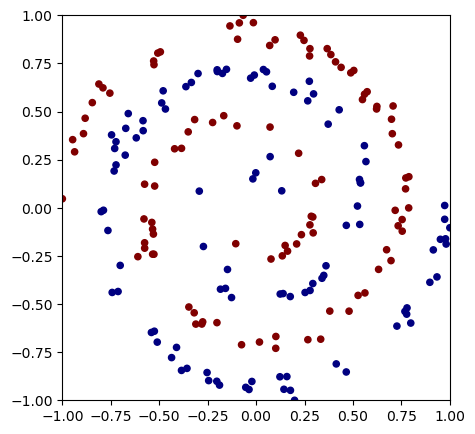

In [2]:
def make_spiral_dataset(n_samples=100, noise=0.2, x=(-1, 1), y=(-1, 1)):
    n = n_samples // 2  # Split samples between two spirals

    # Generate first spiral
    theta1 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r1 = 2 * theta1 + np.pi
    x1 = np.stack([r1 * np.cos(theta1), r1 * np.sin(theta1)], axis=1)

    # Generate second spiral
    theta2 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r2 = -2 * theta2 - np.pi
    x2 = np.stack([r2 * np.cos(theta2), r2 * np.sin(theta2)], axis=1)

    # Combine spirals and add noise
    X = np.vstack([x1, x2])
    X += np.random.randn(n_samples, 2) * noise

    # Scale X to fit within the specified x and y ranges
    X[:, 0] = np.interp(X[:, 0], (X[:, 0].min(), X[:, 0].max()), x)
    X[:, 1] = np.interp(X[:, 1], (X[:, 1].min(), X[:, 1].max()), y)

    # Create labels
    y = np.zeros(n_samples)
    y[:n] = 0  # First spiral
    y[n:] = 1  # Second spiral

    return X, y


# Usage example:
X, y = make_spiral_dataset(n_samples=200, noise=0.9, x=(-1, 1), y=(-1, 1))

print(X.shape, y.shape)

y = y * 2 - 1  # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")
plt.xlim(X[:, 0].min(), X[:, 0].max())
plt.ylim(X[:, 1].min(), X[:, 1].max())
plt.show()

In [3]:
class MLP(Module):
    def __init__(self, inputs: int, outputs: List[int], lr: float = 0.5):
        out_layers = []
        for i in range(len(outputs) - 1):
            out_layers.append(Linear(outputs[i], outputs[i + 1]))
            out_layers.append(Tanh())

        self.layers = Sequential(
            Linear(inputs, outputs[0]),
            Tanh(),
            *out_layers,
        )
        self._optimizer = SGD(self.layers.parameters, lr=lr)

    @property
    def optimizer(self):
        r"""
        Get the optimizer for the MLP.

        Returns:
            Optimizer: The optimizer for the MLP.
        """

        return self._optimizer

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        # x = x.squeeze()
        return x

In [4]:
# initialize a model
model = MLP(2, [64, 32, 16, 1])

print("number of parameters", model.params_count())

number of parameters 2817


In [5]:
# Move dataset to device
X_train, y_train = Tensor(X, device="cuda"), Tensor(y, device="cuda")

loss = MSELoss() # CrossEntropyLoss() # BCELoss() # BCELoss()  # MSELoss()

training_steps = 5000

start_time = time.time()

for step in range(training_steps):
    model.zero_grad()

    # forward pass
    y_pred = model(X_train)
    data_loss = loss(y_pred.squeeze(1), y_train)

    data_loss.backward()

    # update
    # optimizer.step()
    model.optimizer.step()

    if step % 1 == 0:
        print(f"Step {step}, loss: {data_loss.data}")

end_time = time.time()

print(f"Time taken: {end_time - start_time:.2f} seconds")

Step 0, loss: 1.0023778676986694
Step 1, loss: 1.0020521879196167
Step 2, loss: 1.0017353296279907
Step 3, loss: 1.0014235973358154
Step 4, loss: 1.001113772392273
Step 5, loss: 1.0008023977279663
Step 6, loss: 1.0004863739013672
Step 7, loss: 1.0001624822616577
Step 8, loss: 0.9998273253440857
Step 9, loss: 0.9994769096374512
Step 10, loss: 0.9991077780723572
Step 11, loss: 0.9987154006958008
Step 12, loss: 0.9982954859733582
Step 13, loss: 0.9978421330451965
Step 14, loss: 0.9973500370979309
Step 15, loss: 0.9968121647834778
Step 16, loss: 0.9962207078933716
Step 17, loss: 0.9955665469169617
Step 18, loss: 0.9948394298553467
Step 19, loss: 0.9940271377563477
Step 20, loss: 0.9931156635284424
Step 21, loss: 0.9920883178710938
Step 22, loss: 0.9909263253211975
Step 23, loss: 0.9896073937416077
Step 24, loss: 0.9881061911582947
Step 25, loss: 0.9863945841789246
Step 26, loss: 0.9844411015510559
Step 27, loss: 0.9822132587432861
Step 28, loss: 0.9796789884567261
Step 29, loss: 0.97681117

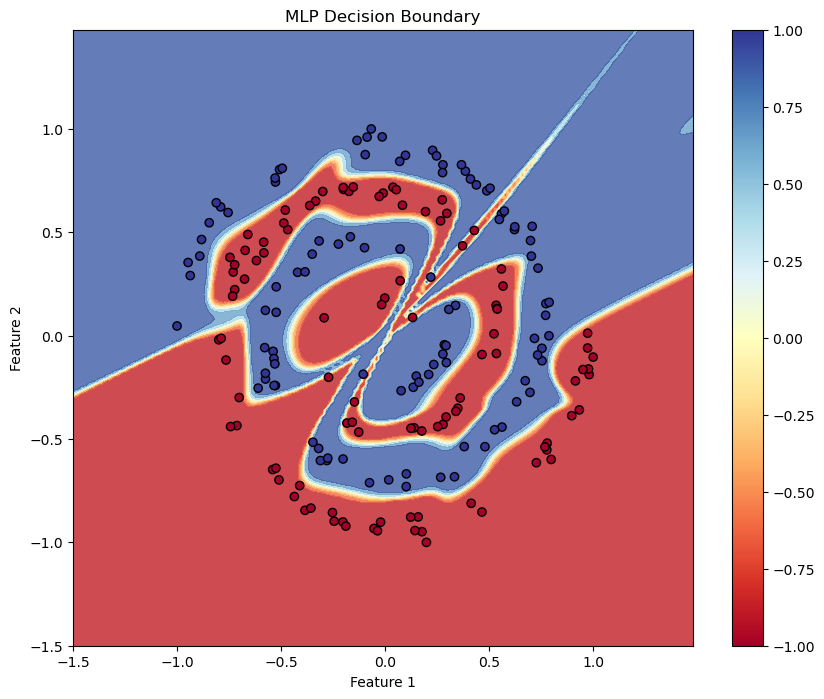

In [6]:
# Create a grid of points for visualization
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Make predictions on the grid points
model.eval()
Z = model(Tensor(grid_points, device="cuda")).to("cpu").data.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu, alpha=0.8)

# Plot the original data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors="black")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("MLP Decision Boundary")
plt.colorbar()
plt.show()